# Testing the DEWFluid 'coder' module


At the moment I have excluded H2O from the free energy calculation=- including it gives unphysical chemical potentials, but I am not sure why. The chemical potential of the O2 component must also be set to zero as part of the open system assumption. Including it as the fO2 means the chemical potential for Si ends up being set to chemical potential of quartz minus chemical potential of O2 in fluid (but the effect of changing Si on the fluid is the same as changing SiO2). This needs more thought!

In [1]:
import numpy as np
from thermoengine import phases
from thermoengine import model
from thermoengine import equilibrate
import pyDEW
import dill
#%run core.ipynb
import importlib
import matplotlib.pyplot as plt


/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/pyximport/pyximport.py:51: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Create the DEWFluid phase object
This imports the manually created coder python module. This is not a coder produced module, but ENKI will treat it as though it is.

In [3]:
DEWFluid = phases.SolutionPhase('DEWFluid_', 'DEW', calib=False, source='coder',coder_module='DEWFluid_module')

Module generated by the coder package does not yet provide a formula method.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.


The system properties are currently hard-coded into the module, the system is set up with the elements:

In [4]:
elements = ['O', 'H', 'Si', 'Na', 'Cl']
basis_species = ['H2O', 'H+', 'H4SIO4(AQ)', 'NA+', 'CL-', 'O2(G)']
other_species = ['H6SI2O7(AQ)', 'H8SI3O10(AQ)', 'H3SIO4-', 'OH-', 'O2(AQ)', 'NACL(AQ)', 'NAOH(AQ)', 'HCL(AQ)']
# elements = pyQ3.defaultsystem.elements
# basis_species = pyQ3.defaultsystem.basis_species_names
# other_species = pyQ3.defaultsystem.other_species_names
sys = pyDEW.System(elements=elements, basis_species=basis_species, other_species=other_species)
sys.elements

['O', 'H', 'Si', 'Na', 'Cl']

# Testing the free energy
Hopefully the calculation is sufficiently precise that we can generate smooth values of the free energy. Here I demonstrate the variation of the solution free energy as salinity is increased.

In [13]:
NaCl_fractions = np.logspace(-4,-0.5,10)
SiO2 = 0.01

mol_fractions = list()

for i in range(np.shape(NaCl_fractions)[0]):
    mols = np.zeros(len(elements))
    mols[0] = 1 - SiO2 - 2*NaCl_fractions[i]
    mols[1] = SiO2
    mols[2] = NaCl_fractions[i]
    mols[3] = NaCl_fractions[i]
    mols[4] = 0.0
    mols = mols/np.sum(mols)
    mol_fractions.append(mols)

free_energies = []

for i in range(np.shape(NaCl_fractions)[0]):
    free_energies.append(DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i]))



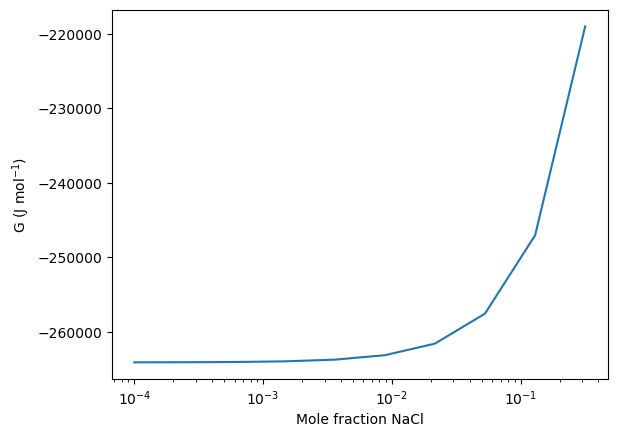

In [14]:
f,a = plt.subplots()
a.plot(NaCl_fractions,free_energies)
a.set_xscale('log')
a.set_ylabel(r'G (J mol$^{-1}$)')
a.set_xlabel('Mole fraction NaCl')
plt.show()

## Testing the first derivative
Testing the derivative is slightly less straightforward. Ideally we want to be able to plot a free energy curve as a reference point for the general behaviour of the derivative, in addition to checking the derivative is smooth. Smoothness is important as this will be controlled by the precision of the calculation and the precision of the output file. The derivatives are controlled by variations in a single component, e.g. Cl.


In [5]:
Si_fractions = np.logspace(-6,-1,10)

mol_fractions = list()

t=573
p=10000

mu_si = np.zeros(10)
molality_si = np.zeros(10)

for i in range(np.shape(Si_fractions)[0]):
    mols = np.zeros(len(elements))
    mols[0] = 1
    mols[1] = Si_fractions[i]
    mols[2] = 0.001
    mols[3] = 0.001
    mols[4] = 0.0
    # mols = mols/np.sum(mols)
    mol_fractions.append(mols)

free_energies = []
dgdn = np.zeros([np.shape(Si_fractions)[0],len(elements)])
d2gdn2 = np.zeros([np.shape(Si_fractions)[0],len(elements),len(elements)])
# dgdSi = list()

for i in range(np.shape(Si_fractions)[0]):
    print(i)
    # try:
    free_energies.append(DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i]))

    output = pyDEW.output.eq3output('eq_working/output')
    
    molality_si[i] = output.basis_species_comp[output.basis_species_comp.species=='H4SIO4'].molality
    # except:
    #     free_energies.append(np.nan)

    dgdn[i,:] = DEWFluid.gibbs_energy(t, p, mol=mol_fractions[i],deriv={'dmol':1})

    # try:
    # d2gdn2[i,:,:] = DEWFluid.gibbs_energy(t, p, mol=mol_fractions[i],deriv={'dmol':2})
    # except:
    #     pass


0
1
2
3
4
5
6
7
8
9


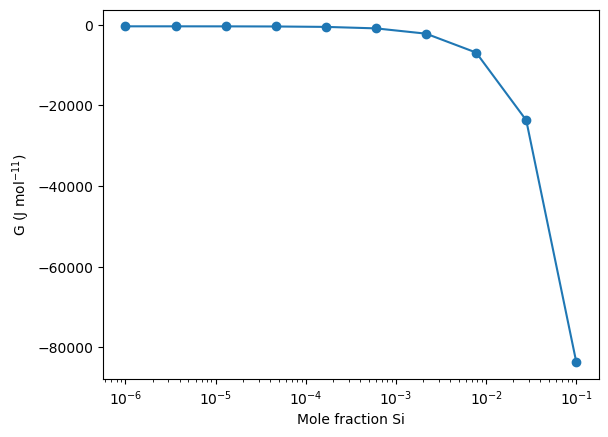

In [6]:
f,a = plt.subplots()
a.plot(Si_fractions, free_energies, marker='o')
a.set_xscale('log')
a.set_ylabel(r'G (J mol$^{-11}$)')
a.set_xlabel('Mole fraction Si')
plt.show()

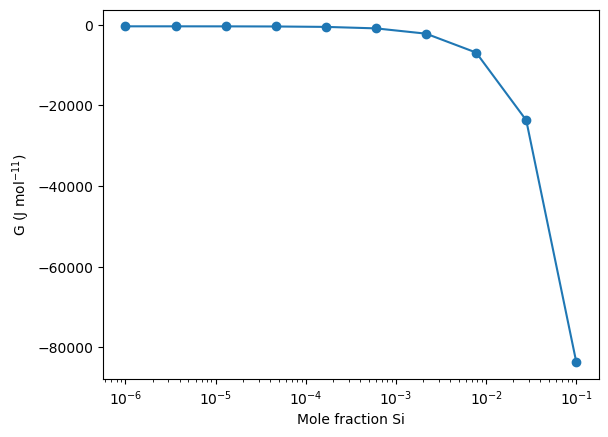

In [28]:
f,a = plt.subplots()
a.plot(Si_fractions, free_energies, marker='o')
a.set_xscale('log')
a.set_ylabel(r'G (J mol$^{-11}$)')
a.set_xlabel('Mole fraction Si')
plt.show()

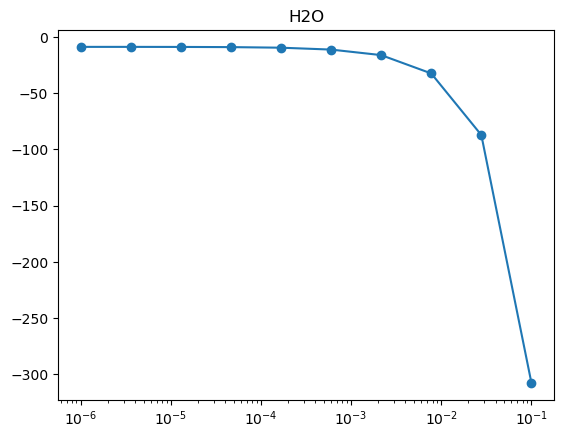

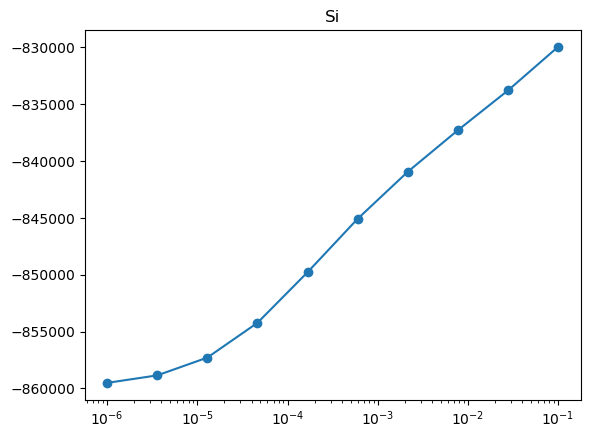

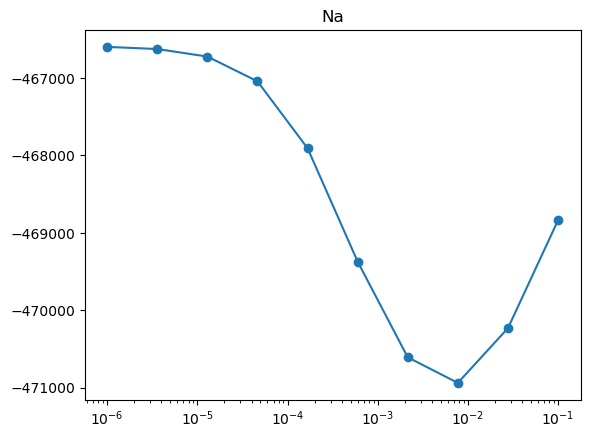

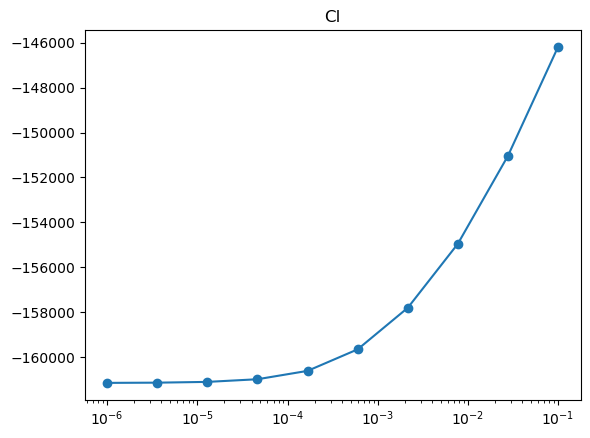

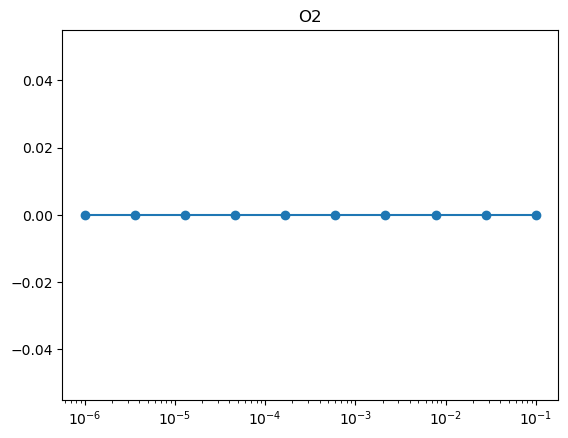

In [7]:
for i in range(5):
    f, a = plt.subplots()
    a.plot(Si_fractions, dgdn[:,i], marker='o',label=['H2O', 'Si', 'Na', 'Cl', 'O2'][i])
    a.set_title(['H2O', 'Si', 'Na', 'Cl', 'O2'][i])
    a.set_xscale('log')
    plt.show()

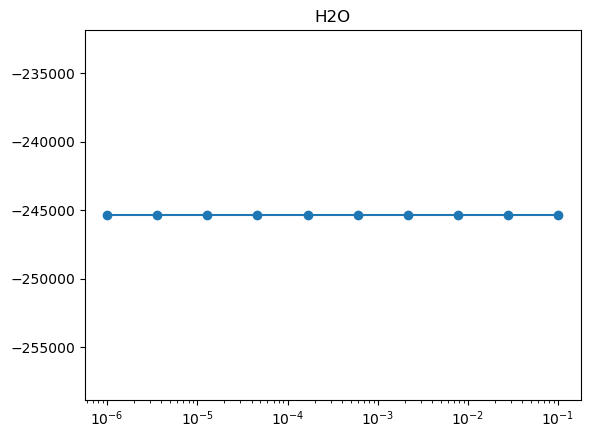

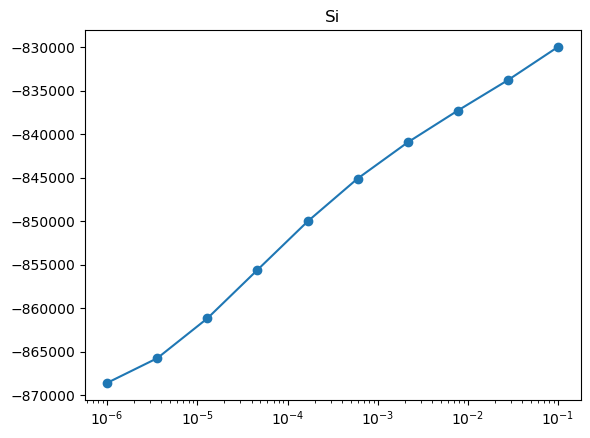

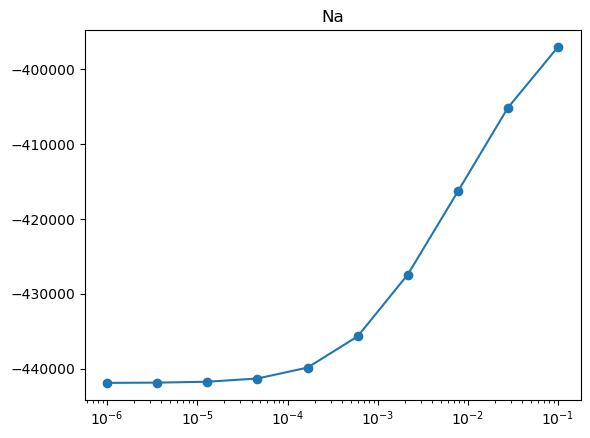

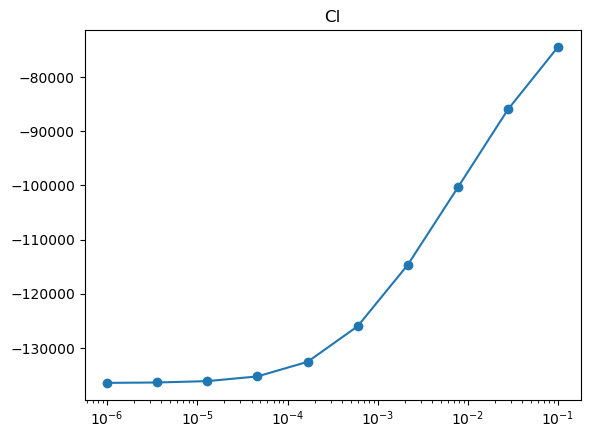

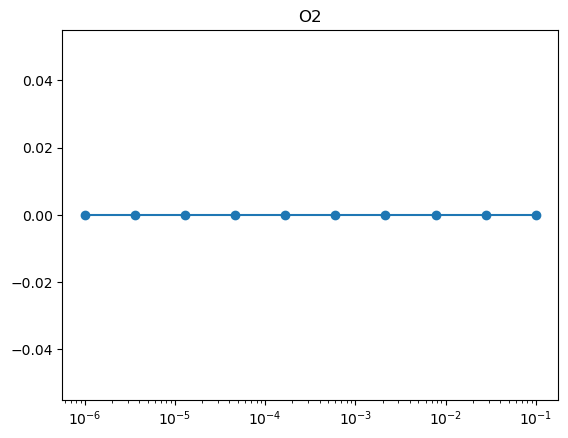

In [8]:
for i in range(5):
    f, a = plt.subplots()
    a.plot(Si_fractions, dgdn[:,i], marker='o',label=['H2O', 'Si', 'Na', 'Cl', 'O2'][i])
    a.set_title(['H2O', 'Si', 'Na', 'Cl', 'O2'][i])
    a.set_xscale('log')
    plt.show()

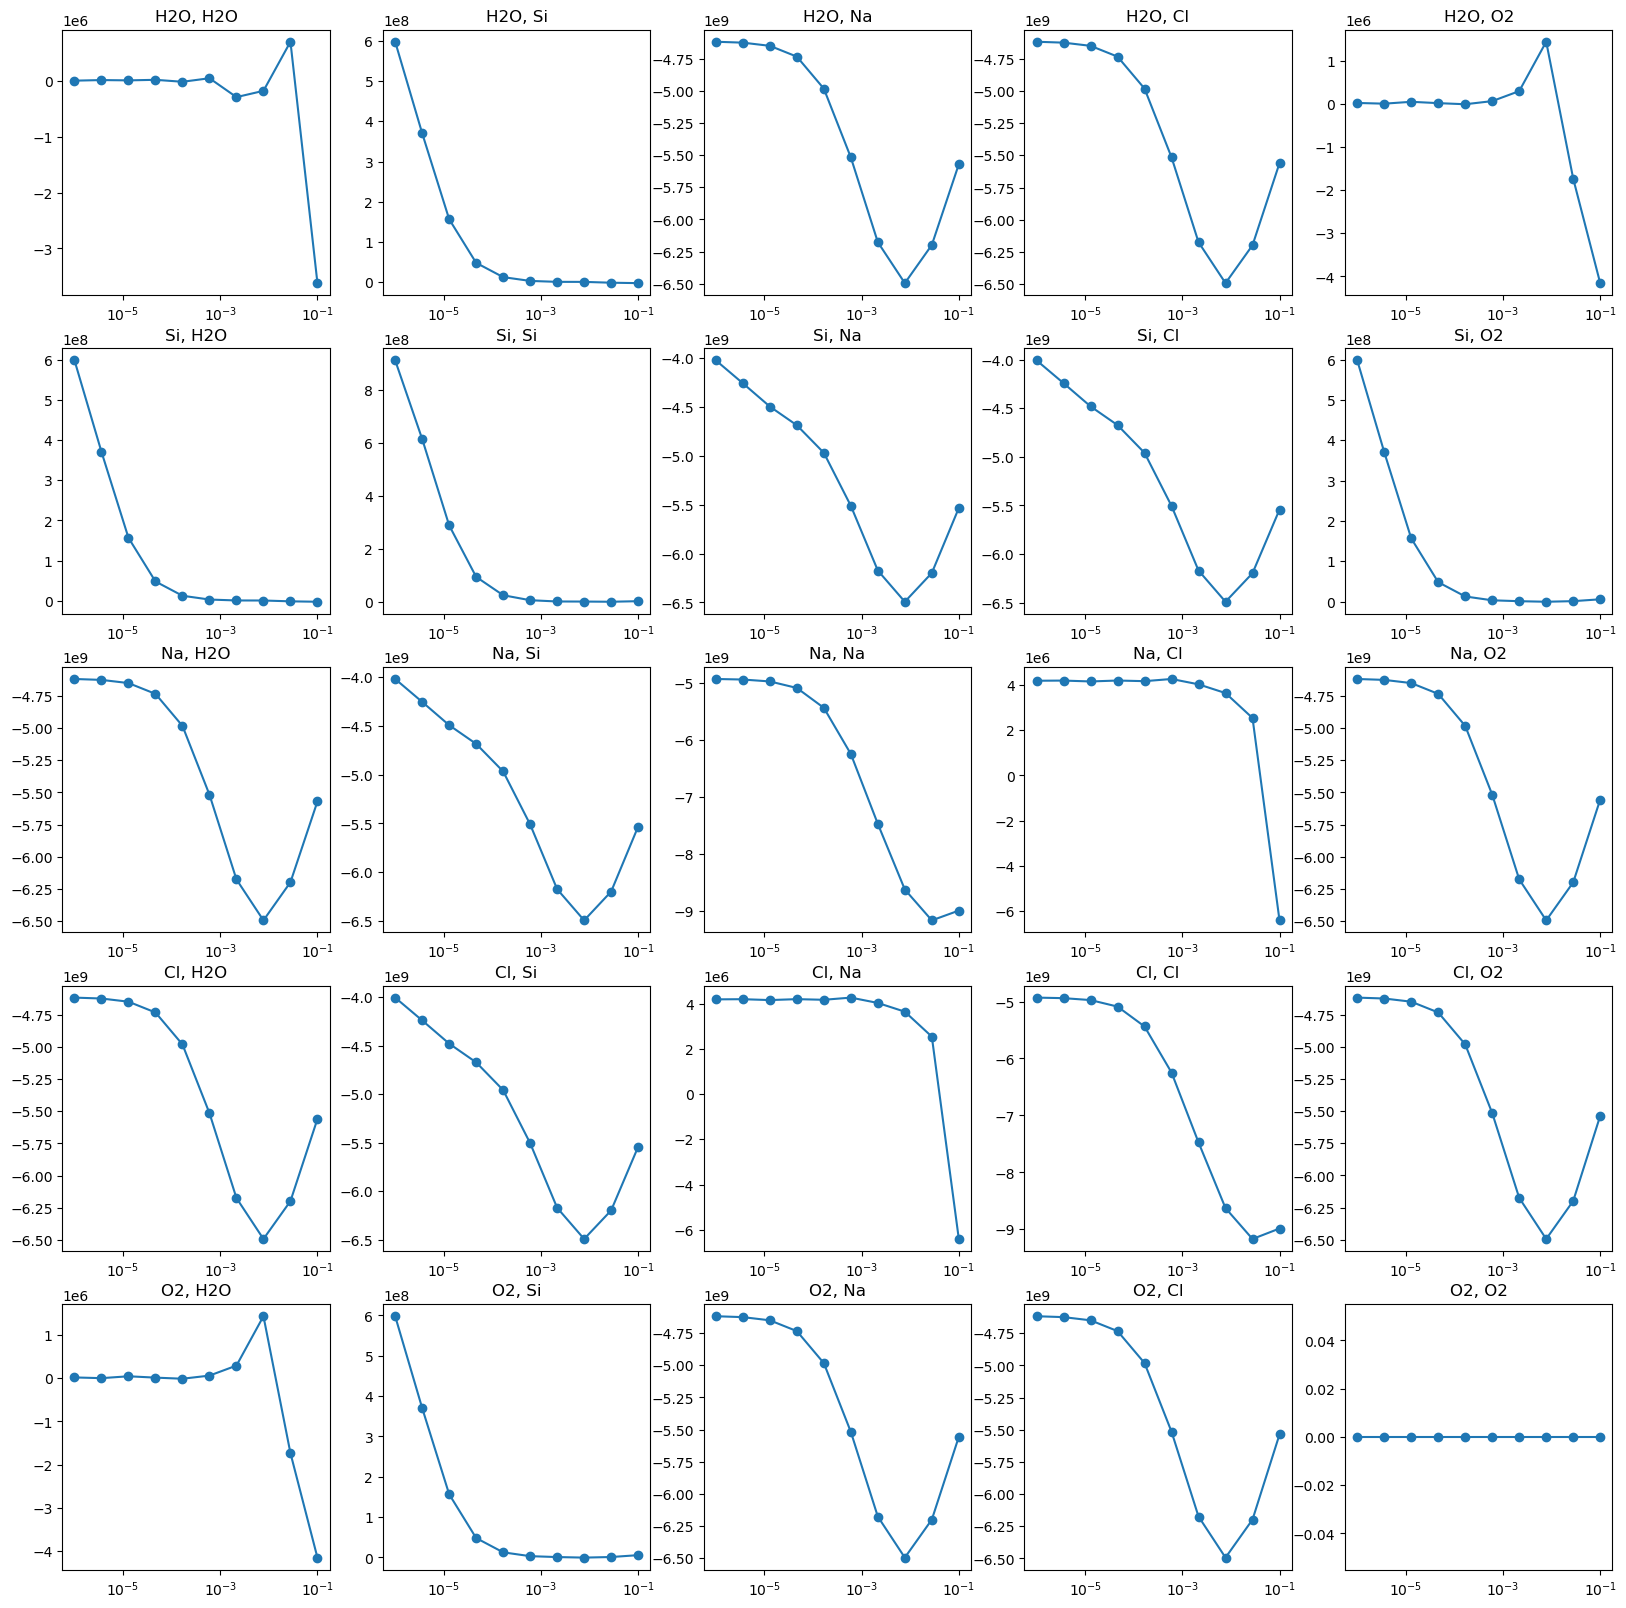

In [9]:
f, a = plt.subplots(5, 5, figsize=(20,20))
# a = np.ravel(a).tolist()


components = ['H2O', 'Si', 'Na', 'Cl', 'O2']

for i in range(5):
    for j in range(5):
        a[i,j].plot(Si_fractions,d2gdn2[:,i,j], marker='o')
        a[i,j].set_title(components[i] + ', ' + components[j])
        a[i,j].set_xscale('log')

plt.show()

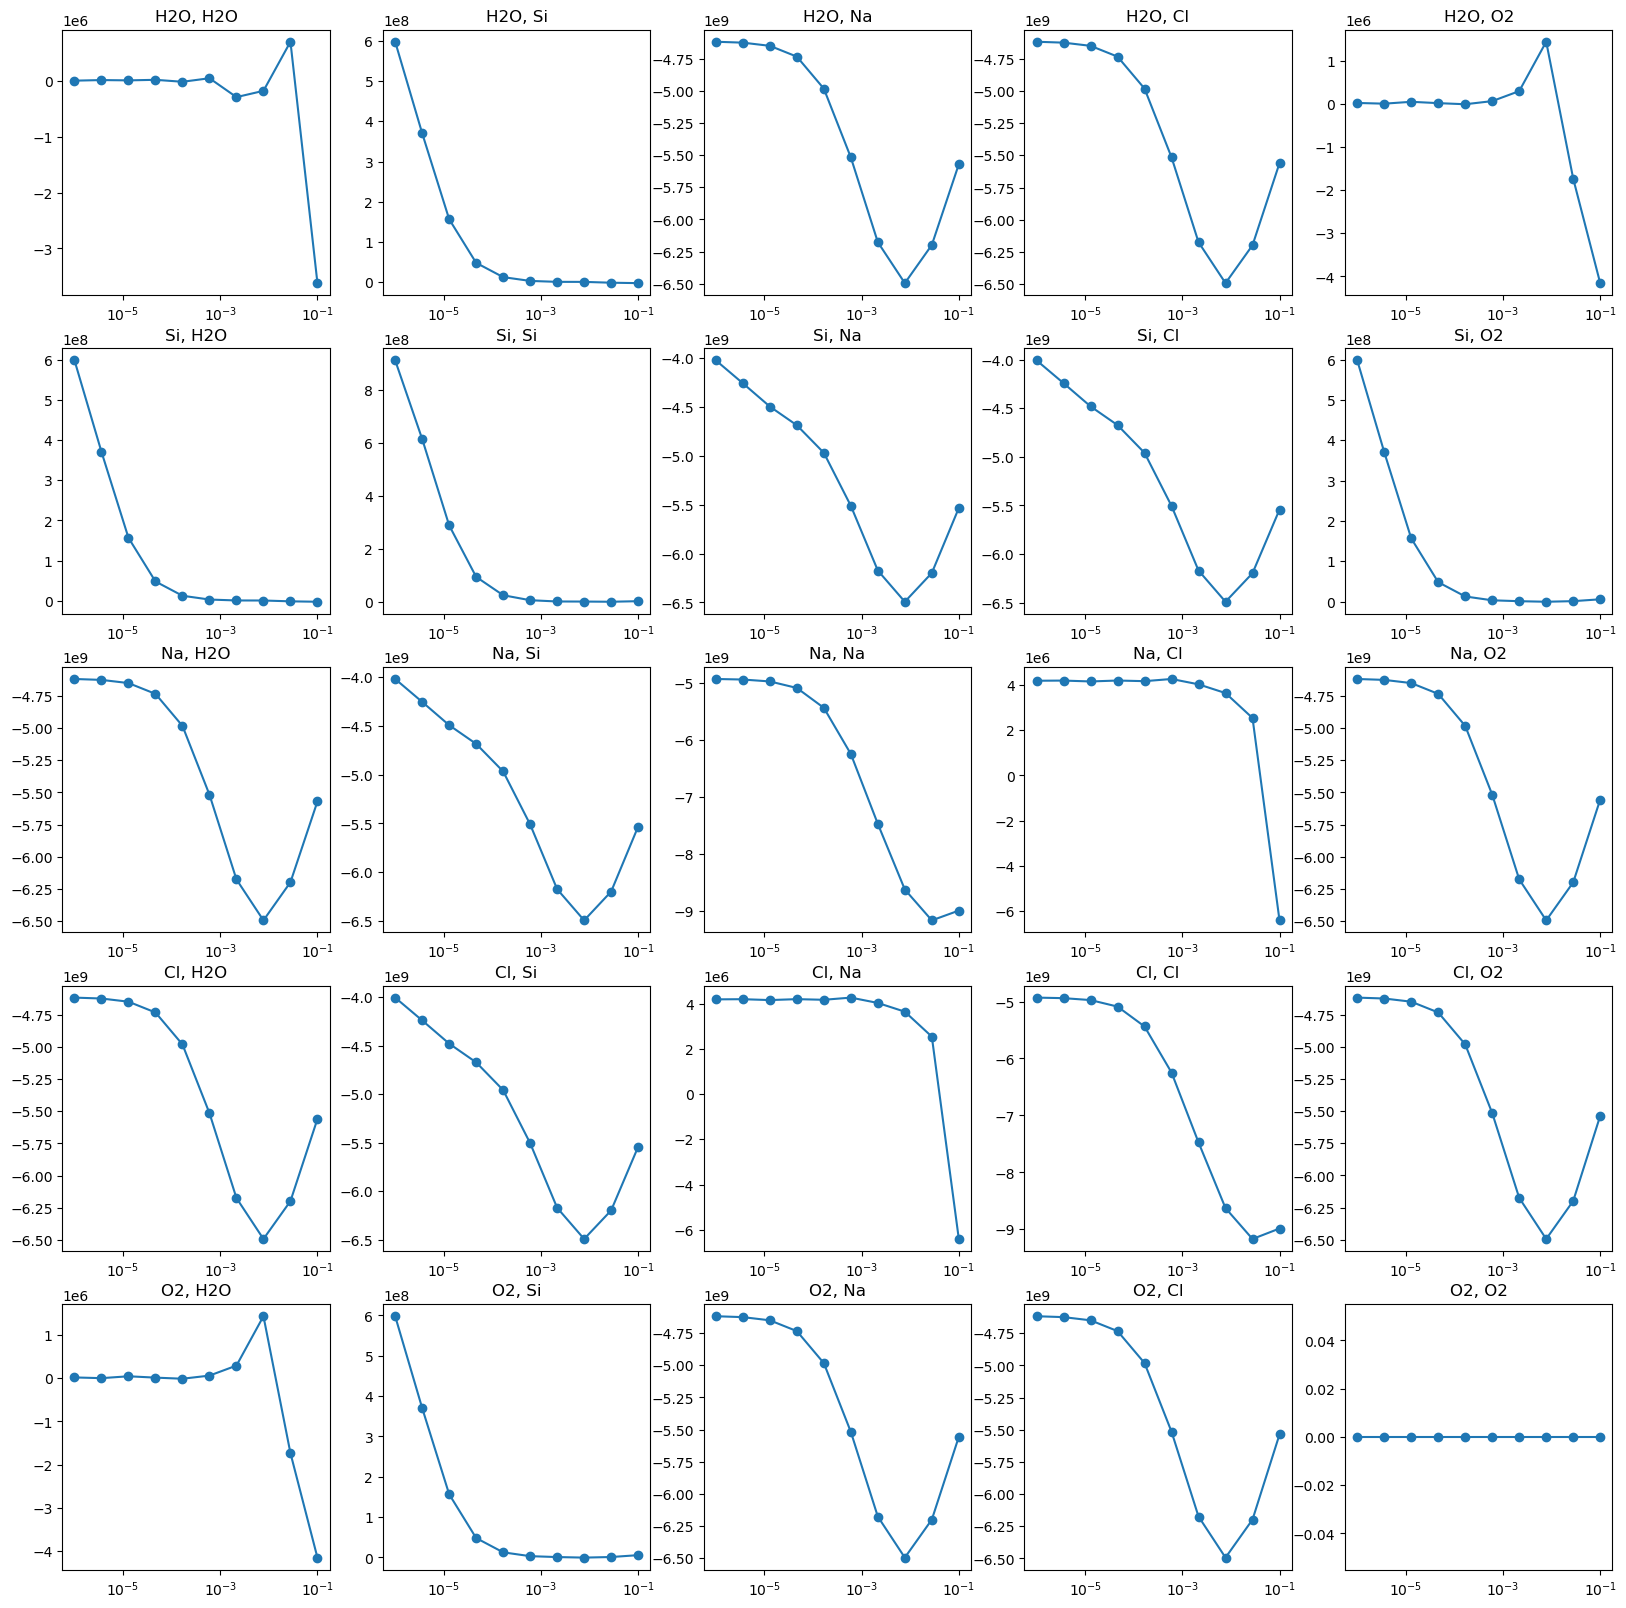

In [9]:
f, a = plt.subplots(5, 5, figsize=(20,20))
# a = np.ravel(a).tolist()


components = ['H2O', 'Si', 'Na', 'Cl', 'O2']

for i in range(5):
    for j in range(5):
        a[i,j].plot(Si_fractions,d2gdn2[:,i,j], marker='o')
        a[i,j].set_title(components[i] + ', ' + components[j])
        a[i,j].set_xscale('log')

plt.show()

In [37]:
pyDEW.__path__

['/Users/sm905/opt/anaconda3/lib/python3.9/site-packages/pyDEW']

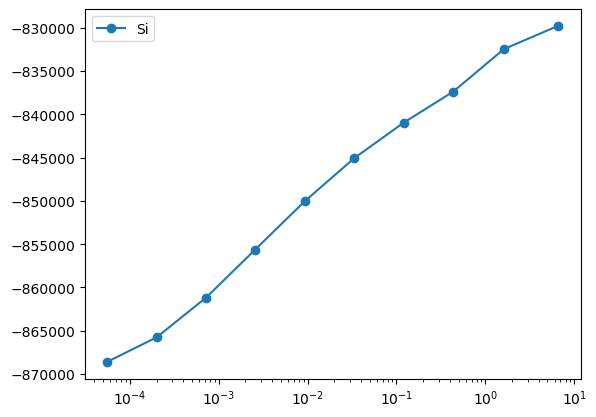

In [7]:
f,a = plt.subplots()
# for i in range(len(elements)):
#     a.plot(Si_fractions,-dgdn[:,i],label=['H2O', 'Si', 'Na', 'Cl', 'O2'][i])
a.plot(molality_si, dgdn[:,1], marker='o',label=elements[2])
# + muO2(t, p, None)
a.set_xscale('log')
# a.set_yscale('log')
a.legend()
plt.show()

In [20]:
qz.gibbs_energy(573, 10000)

-850067.2283891743

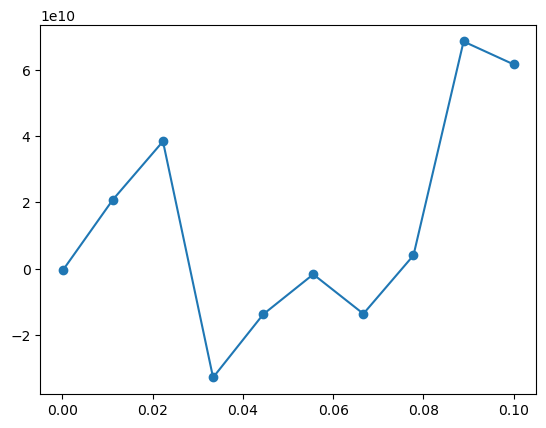

In [17]:
f,a = plt.subplots()
# for i in range(len(elements)):
#     a.plot(Si_fractions,dgdn[:,i],label=elements[i])

a.plot(Si_fractions,d2gdn2[:,2,2], marker='o')

# a.plot(Si_fractions,-d2gdn2[:,2,2])
# a.plot(Si_fractions[1:],dgdSi,ls='--')
# a.set_xscale('log')
# a.set_yscale('log')
# a.legend()
plt.show()

In [30]:
sys_compare = pyDEW.System()


t = 723.15
p = 10000.0

mineral_eq = {'H4SIO4(AQ)' : 'QUARTZ_ALPHA'}
molalities = {'NA+': 0.0,
              'CL-': 0.0}

fl_comp = pyDEW.Fluid(sys_compare, t, p, mineral_eq=mineral_eq, molalities=molalities, eq3_executable_name='EQ3_longoutput')

In [31]:
fl_comp.elemental_comp

,ppm,molality
element,,
O,895198.3071,55.951992
H,112323.8887,111.443485
SI,3233.3405,0.115125


## Test in the Equilibrate algorithm

In [8]:
from thermoengine import core, equilibrate

In [9]:
elm_sys = ['O', 'H', 'Si', 'Na', 'Cl']
elm_sys

['O', 'H', 'Si', 'Na', 'Cl']

In [10]:
phs_sys = [DEWFluid]

Bulk composition is defined in terms of moles **ELEMENTS** not the DEW endmembers

In [8]:
# mol_elm = [0.5, 0.49, 0.005, 0.005]
mol_elm = [
           2.0, # H
           1.0 + 0.2, # O
           0.01, # Na
           0.1, # Si
           0.01, # Cl
           ]


mol_elm = np.array(mol_elm)

mol_elm = mol_elm/np.sum(mol_elm)
mol_elm

array([0.60240964, 0.36144578, 0.00301205, 0.03012048, 0.00301205])

In [9]:
blk_cmp = mol_elm

### Simple Equilibrate run- no fO2 constraint- only DEW

I think there are two problems here:
1. The element order is getting mixed up somewhere between the thermoengine phase object and the pyDEW fluid object
2. The dgdn algorithm is trying to calculate the gradient for changing the amount of O in the phase, which is currently set at 0. Though I am not sure why this didn't flag up as a problem in the tests before this in the notebook... Should probably start there with trying to chase the problem.

In [12]:
equil = equilibrate.Equilibrate(elm_sys, phs_sys)

In [13]:
t = 723.15
p = 10000.0
state = equil.execute(t, p, bulk_comp=blk_cmp, debug=3, stats=True)
state.print_state()

DEW is the omnicomponent phase.
Stable phase assemblage computed. Exiting.
 
T =     450.00 °C, P =     1000.0 MPa
DEW             moles:   0.367470 grams:   7.412
            H2O form:  H2O            X:  0.8197  wt%    SiO2   24.69
             Si form:  Si             X:  0.0820  wt%    Na2O    1.27
             Na form:  Na             X:  0.0082  wt%     H2O   74.03
             Cl form:  Cl             X:  0.0082  
             O2 form:  O2             X:  0.0820  


In [14]:
state.dGdn()

array([[-1.66896332e+05],
       [ 1.45912141e-11],
       [-3.58424154e+05],
       [-4.00638922e+05],
       [-8.50594834e+04]])

### Add in fO2 constraint

In [6]:
def muO2_std(t, p):
        tr = 298.15
        hs = 23.10248*(t-tr) + 2.0*804.8876*(np.sqrt(t)-np.sqrt(tr)) - 1762835.0*(1.0/t-1.0/tr) \
           - 18172.91960*np.log(t/tr) + 0.5*0.002676*(t*t-tr*tr)
        ss = 205.15 + 23.10248*np.log(t/tr)  - 2.0*804.8876*(1.0/np.sqrt(t)-1.0/np.sqrt(tr)) \
           - 0.5*1762835.0*(1.0/(t*t)-1.0/(tr*tr)) + 18172.91960*(1.0/t-1.0/tr) + 0.002676*(t-tr)
        return hs - t*ss + 205.15*298.15

def muO2(t, p, state):
    std = muO2_std(t, p)
    mu = std + 8.314*t*np.log(10**-12.0)
    return mu

In [7]:
muO2(100.0, 1000.0, None)

14529.923494307459

In [11]:
qz = None
for i in range(len(pyDEW.defaultsystem.minerals)):
    if pyDEW.defaultsystem.minerals[i] == 'QUARTZ_ALPHA' and qz is None:
        qz = sys.minerals[i]

In [12]:
phs_sys = [DEWFluid, qz]

In [13]:
# mol_elm = [0.5, 0.49, 0.005, 0.005]
# mol_elm = [
#            1.0 + 0.2, # O
#            2.0, # H
#            0.1, # Si
#            0.0, # Na
#            0.0, # Cl
#            ]


# mol_elm = [
#            2.0, # H
#            1.0 + 0.2, # O
#            0.01, # Na
#            0.1, # Si
#            0.01, # Cl
#            ]

mol_elm = [
           2.0, # H
           1.0 + 0.4, # O
           0.0, # Na
           0.1, # Si
           0.0, # Cl
           ]

mol_elm = np.array(mol_elm)

mol_elm = mol_elm/np.sum(mol_elm)
mol_elm

array([0.57142857, 0.4       , 0.        , 0.02857143, 0.        ])

In [14]:
blk_cmp = mol_elm

In [15]:
equil = equilibrate.Equilibrate(elm_sys, phs_sys,)# lagrange_l=[({'O':2.0},muO2)]) 

In [16]:
t = 723.15
p = 10000.0
state = equil.execute(t, p, bulk_comp=blk_cmp, debug=3, stats=True)
state.print_state()

DEW is the omnicomponent phase.
******************************** 
Calculating saturation state for QUARTZ_ALPHA
Target chemical potentials:  [-843536.2953736]
-843536.2953735982 -862654.72560214
Affinity, mole fraction -19118.43022854172 [1.]
 
Adding phase  QUARTZ_ALPHA  to system. with affinity =  -19118.43022854172
Add: QUARTZ_ALPHA
... phase successfully added.
Zero element projection matrix (6, 4)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
RQ = A, R matrix (3, 4)
[[ 0.         -1.8516402  -0.75592895  0.        ]
 [ 0.          0.         -2.64575131 -1.41421356]
 [ 0.          0.          0.         -1.41421356]]
RQ = A, Q matrix (4, 4)
[[ 0.         -0.57735027 -0.57735027  0.57735027]
 [-0.9258201  -0.15430335  0.3086067   0.15430335]
 [-0.37796447  0.37796447 -0.75592895 -0.37796447]
 [ 0.         -0.70710678  0.         -0.70710678]]
Exit constraint matrix and RQ decomposition.
... df 1 A (3, 4)
[[2. 0. 0. 0.]
 [1. 0. 2. 2.]
 [0

In [16]:
state.compositions('DEW')

array([3.01204819e-01, 2.23468973e-04, 3.01204819e-03, 3.01204819e-03,
       2.23468973e-04])

In [30]:
DEWFluid.gibbs_energy(t, p, mol=state.compositions('DEW'), deriv={'dmol':1})

array([[-4.21787242e+00, -8.62653178e+05, -5.12304008e+05,
        -1.92334203e+05,  0.00000000e+00]])

In [31]:
altered = np.array([3.01204819e-01, 2.23468973e-04*3, 3.01204819e-03, 3.01204819e-03, 2.23468973e-04])

DEWFluid.gibbs_energy(t, p, mol=altered, deriv={'dmol':1})

array([[-1.08095169e+02, -8.57839163e+05, -4.40770345e+05,
        -1.24857525e+05,  0.00000000e+00]])

In [20]:
qz.gibbs_energy(t, p)

-862654.72560214

Convert to molality:

In [24]:
output = pyDEW.output.eq3output('eq_working/output')

In [25]:
output.elemental_comp

,element,ppm,molality
0,O,890640.2412,.5566710259E+02
1,H,112051.0334,.1111727685E+03
2,SI,1133.5076,.4035917568E-01
3,NA,.0000,.4319929856E-13
4,CL,.0000,.4319929856E-13


In [27]:
output.aqueous_species.molality.sum()

0.03744873945262148

In [29]:
0.115/0.0404235

2.8448798347495887

In [17]:
qz.gibbs_energy(t, p)

-862654.72560214

In [18]:
DEWFluid.gibbs_energy(t, p, mol=state.compositions('DEW'), deriv={'dmol':1})

array([[-280067.29262958, -400925.45017374, -460211.37807342,
         -17923.03076651, -321013.40059478]])

In [44]:
state.compositions('DEW')

array([0.30120482, 0.03009882, 0.00301205, 0.00301205, 0.03009882])

In [19]:
newmol = np.array([0.30120482, 0.001, 0.00301205, 0.00301205, 0.03009882])
newmol = newmol/np.sum(newmol)

In [20]:
DEWFluid.gibbs_energy(t, p, mol=newmol, deriv={'dmol':1})

array([[-281115.41978154, -370800.38780278, -420302.16208357,
         -21853.58999162, -321013.40059478]])

In [11]:
np.sum(np.array([0.30120482, 0.03009882, 0.00301205, 0.00301205, 0.03009882]))

0.36742655999999996

In [36]:
state.tot_grams_phase('QUARTZ_ALPHA')

0.0

In [ ]:
dew_end = [
           1.2, # O -> H2O
           0.1, # Si
           0.0, # Na
           0.0, # Cl
           9,9
           ]

In [ ]:
DEWFluid.chem_potential(450+273.15, 10000.0, mol=mol_elm)

In [87]:
DEWFluid.gibbs_energy(450+273.15, 10000.0, mol=[2.04, 1.04, 1e-11, 0.1, 1e-11], deriv={'dmol':1})

array([[      0.        , -136052.38984209, -905629.33359101,
        -567622.25081597,  119472.07848746]])

In [86]:
qz.chem_potential(450+273.15, 10000.0)

-864111.672609022

### Try simple calculation with quartz

In [41]:
berman = model.Database()

In [42]:
qz = berman.get_phase('Qz')
coe = berman.get_phase('Coe')

In [43]:
qz.enable_gibbs_energy_reference_state()
coe.enable_gibbs_energy_reference_state()

In [64]:
mol_elm = [2.04, 1.04, 1e-11, 0.5, 1e-11]
# mol_elm = [1.4, 2.4, 0.1, 0.01, 0.01]
mol_elm = mol_elm/np.sum(mol_elm)
mol_elm

array([5.69832402e-01, 2.90502793e-01, 2.79329609e-12, 1.39664804e-01,
       2.79329609e-12])

In [65]:
blk_cmp = mol_elm

In [66]:
phs_sys = [DEWFluid, qz, coe]
elm_sys = ['H', 'O', 'Si', 'Na', 'Cl']

In [67]:
equil = equilibrate.Equilibrate(elm_sys, phs_sys)

In [68]:
t = 400.0 + 273.15
p = 1000.0
state = equil.execute(t, p, bulk_comp=blk_cmp, debug=3, stats=True)
state.print_state()

DEW is the omnicomponent phase.
******************************** 
Calculating saturation state for Quartz
Target chemical potentials:  [-898659.85883497]
-898659.8588349702 -880041.1301162987
Affinity, mole fraction 18618.728718671482 [1.]
 
******************************** 
Calculating saturation state for Coesite
Target chemical potentials:  [-898659.85883497]
-898659.8588349702 -874508.9640812244
Affinity, mole fraction 24150.894753745757 [1.]
 
Stable phase assemblage computed. Exiting.
 
T =     400.00 °C, P =      100.0 MPa
DEW             moles:   1.000000 grams:   9.145
              O form:  O              X:  0.2905  wt%    SiO2   62.05
              H form:  H              X:  0.5698  wt%    Na2O    0.00
             Si form:  Si             X:  0.1397  wt%     H2O   37.95
             Na form:  Na             X:  0.0000  
             Cl form:  Cl             X:  0.0000  
Quartz          affn:   18618.73
Coesite         affn:   24150.89


In [69]:
DEWFluid.test_endmember_comp(mol_elm)

True

In [70]:
state.moles_elements('DEW')

array([5.69832402e-01, 2.90502793e-01, 2.79329609e-12, 1.39664804e-01,
       2.79329609e-12])

In [73]:
state.dGdn(t=400+273.15, p=1000.0)

array([[-104263.10984826],
       [      0.        ],
       [-612501.54004293],
       [-898659.85883497],
       [ -59320.16277963]])

In [23]:
pyDEW.defaultsystem.hydrated_species

{'AL(OH)4-': 2,
 'AL(OH)SI(OH)-': 3,
 'CA(H3SIO4)+': 1,
 'FE(OH)2(AQ)': 1,
 'AL(OH)3(AQ)': 1,
 'FE(OH)3-': 1,
 'H3SIO4-': 1,
 'MG(H3SIO4)+': 1,
 'MGSIC+': 1,
 'H6SI2O7(AQ)': 3,
 'H8SI3O10(AQ)': 4,
 'H4SIO4(AQ)': 2}